In [66]:
# https://www.rdkit.org/
#https://github.com/rdkit/rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np

#https://github.com/mordred-descriptor/mordred
#from mordred import Calculator, descriptors


from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xsmiles
import json
import shap

In [67]:
file_path = 'udataset.xlsx'
#file_path = "new.xlsx"

In [68]:
df = pd.read_excel(file_path)
df.head()

,Substance,Substance_lower,CAS_number,Smiles_code,Additional info,Irritation,Source
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN


In [69]:

def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    descriptors = {}
    for descriptor, function in Descriptors.descList:
        try:
            descriptors[descriptor] = function(mol)
        except:
            descriptors[descriptor] = None

    return descriptors

descriptors_series = df['Smiles_code'].apply(calculate_descriptors)

# Create a new DataFrame to store descriptors
descriptors_df = pd.DataFrame(descriptors_series.tolist())

# Concatenate the original dataframe with the descriptors dataframe
df = pd.concat([df, descriptors_df], axis=1)


[20:32:58] WARNING: not removing hydrogen atom without neighbors
[20:32:58] WARNING: not removing hydrogen atom without neighbors
[20:32:58] WARNING: not removing hydrogen atom without neighbors


In [37]:

# Function to calculate fingerprint descriptors
def calculate_fingerprint(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Calculate the Morgan fingerprint (radius 2, 1024 bits by default)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    
    # Convert fingerprint to a list of bits
    return list(fingerprint)

# Apply the function to your dataframe column containing SMILES codes
fingerprint_series = df['Smiles_code'].apply(calculate_fingerprint)

# Convert the series of fingerprints (lists) to a DataFrame
fingerprint_df = pd.DataFrame(fingerprint_series.tolist())

# Concatenate the original dataframe with the fingerprint dataframe
df = pd.concat([df, fingerprint_df], axis=1)


[19:36:51] WARNING: not removing hydrogen atom without neighbors


In [70]:
df.head()

,Substance,Substance_lower,CAS_number,Smiles_code,Additional info,Irritation,Source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf,9.768009,9.768009,0.750000,...,0,0,0,0,0,0,0,0,3,0
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN,10.535393,10.535393,0.116191,...,0,0,0,0,0,0,0,0,0,0
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN,3.350347,3.350347,1.167500,...,0,0,0,0,0,0,0,0,1,0
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN,8.629773,8.629773,0.329353,...,0,0,0,0,0,0,0,0,0,0
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN,3.974575,3.974575,0.767315,...,0,0,0,0,0,0,0,0,0,0


In [72]:
columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "Smiles_code", "Additional info", "Source"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)
df.head()

KeyError: "['Substance', 'Substance_lower', 'CAS_number', 'Smiles_code', 'Additional info', 'Source'] not found in axis"

In [73]:
total_rows = len(df)
nan_columns = df.columns[df.isnull().any()].tolist()
nan_info = df[nan_columns].isnull().sum()
nan_percentage = (nan_info / total_rows) * 100
nan_info = pd.DataFrame({'NaN Count': nan_info, 'NaN Percentage': nan_percentage})
print(nan_info)

                     NaN Count  NaN Percentage
MaxPartialCharge             4        0.896861
MinPartialCharge             4        0.896861
MaxAbsPartialCharge          4        0.896861
MinAbsPartialCharge          4        0.896861
BCUT2D_MWHI                 35        7.847534
BCUT2D_MWLOW                35        7.847534
BCUT2D_CHGHI                35        7.847534
BCUT2D_CHGLO                35        7.847534
BCUT2D_LOGPHI               35        7.847534
BCUT2D_LOGPLOW              35        7.847534
BCUT2D_MRHI                 35        7.847534
BCUT2D_MRLOW                35        7.847534


In [74]:
columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)

In [75]:
# Count the number of rows before dropping NaN values
num_rows_before = df.shape[0]

# Drop rows with NaN values
df.dropna(inplace=True)

# Count the number of rows after dropping NaN values
num_rows_after = df.shape[0]

# Calculate the number of rows dropped
num_rows_dropped = num_rows_before - num_rows_after

print("Number of rows dropped:", num_rows_dropped)

Number of rows dropped: 4


In [76]:
def detect_outliers(df):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_mask = (df < lower_bound) | (df > upper_bound)
    
    # Replace outliers with median
    median_values = df.median(axis=1)
    df = df.where(~outlier_mask, median_values, axis=0)


    outliers = df[outlier_mask.any(axis=1)]
    num_outliers = outliers.shape[0]
    print(f"Number of outliers detected: {num_outliers}")

    return df

In [77]:

df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})
df.head()

/var/folders/n4/lx5wz8kj2r79g9p8wxdnqk580000gn/T/ipykernel_24084/744444035.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})


,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,1,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,1,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,1,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,1,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [78]:
df = detect_outliers(df)

Number of outliers detected: 439


/var/folders/n4/lx5wz8kj2r79g9p8wxdnqk580000gn/T/ipykernel_24084/3864272335.py:18: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.where(~outlier_mask, median_values, axis=0)


In [79]:
#Remove features with zero variance and highly correlated features
def feature_selection(df, nonzero_thrd=0.0, cor_thrd=0.95):

    # Remove features with zero variance
    nonzero_df = df.loc[:, df.var() > nonzero_thrd]

    # Remove highly correlated features
    corr_matrix = nonzero_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_thrd)]
    
    return nonzero_df.drop(to_drop, axis=1)


df = feature_selection(df)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,fr_imidazole,fr_ketone,fr_methoxy,fr_para_hydroxylation,fr_pyridine,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_thiophene,fr_urea
0,1,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,0.119490,-0.303403,0.303403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,0.122624,-0.303088,0.303088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.000000,0.000000,1.167500,0.429137,9.000000,151.047,0.003125,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,0.043307,-0.396366,0.396366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3.974575,0.767315,0.767315,0.485034,0.000000,136.238,-0.017096,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
normalized_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
df = pd.DataFrame(normalized_data, columns=df.columns)

df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,fr_imidazole,fr_ketone,fr_methoxy,fr_para_hydroxylation,fr_pyridine,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_thiophene,fr_urea
0,1.0,0.648191,0.841558,0.816337,0.378529,0.466241,0.209837,0.232062,0.548769,0.303403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.699113,0.130376,0.702564,0.713980,0.694891,0.375455,0.234795,0.549237,0.303088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000000,0.000000,0.891282,0.417235,0.459854,0.277571,0.130574,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.572659,0.369560,0.740828,0.619348,0.650299,0.287167,0.165618,0.410511,0.396366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.263747,0.860987,0.819445,0.480844,0.000000,0.250357,0.112937,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


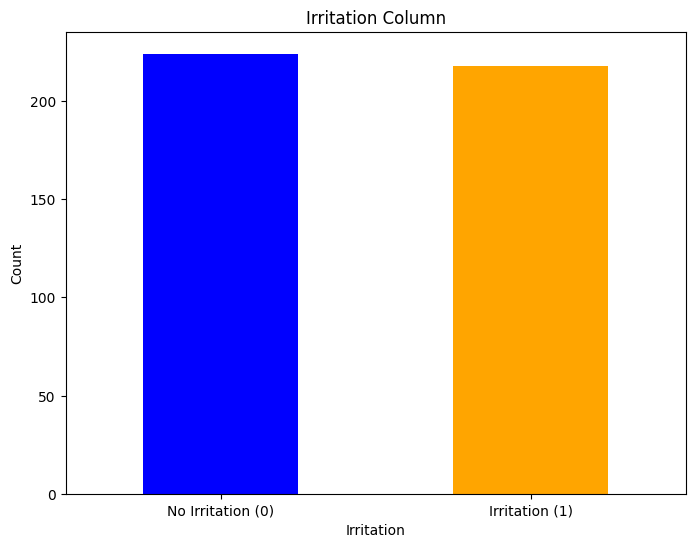

In [81]:
# Plotting class imbalance
plt.figure(figsize=(8, 6))
df['Irritation'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Irritation Column')
plt.xlabel('Irritation')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Irritation (0)', 'Irritation (1)'], rotation=0)
plt.show()

In [82]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (353, 127)
Shape of X_test: (89, 127)
Shape of y_train: (353,)
Shape of y_test: (89,)


In [83]:
y_train

165    0.0
394    1.0
21     1.0
129    0.0
315    0.0
      ... 
329    0.0
307    0.0
191    1.0
26     0.0
327    0.0
Name: Irritation, Length: 353, dtype: float64

In [84]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV


In [85]:
def print_score(y_train,y_pred_train, y_test, y_pred_test):
    # Calculate accuracy on training set
    accuracy_train = accuracy_score(y_train, y_pred_train)
    #print("Training Accuracy: %.2f%%" % (accuracy_train * 100.0))
    print("%.2f%%" % (accuracy_train * 100.0))

    # Calculate accuracy on validation set
    accuracy_valid = accuracy_score(y_test, y_pred_test)
    #print("Validation Accuracy: %.2f%%" % (accuracy_valid * 100.0))
    print("%.2f%%" % (accuracy_valid * 100.0))

    # Calculate precision and recall
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    #print("Precision: %.2f%%" % (precision * 100.0))
    #print("Recall: %.2f%%" % (recall * 100.0))
    print("%.2f%%" % (precision * 100.0))
    print("%.2f%%" % (recall * 100.0))

In [35]:
def xgboost(X_train, X_test, y_train, y_test):
    param_grid = {
        'max_depth': [1, 3],
        'min_child_weight': [6, 10],
        'gamma': [0.1, 0.5],
        'subsample': [0.6],
        'colsample_bytree': [0.6, 0.8],
        'reg_alpha': [0.5, 1],
        'reg_lambda': [0.5, 1]
    }
    # Create an instance of the XGBClassifier
    model = xgb.XGBClassifier()
    
    # Set up parameters for early stopping
    early_stopping_rounds = 10
    eval_set = [(X_test, y_test)]

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    # Get the best parameters
    best_params = grid_search.best_params_

    print(best_params)

    # Use the best parameters to train the final model
    model = xgb.XGBClassifier(early_stopping_rounds=early_stopping_rounds, **best_params)
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # Make predictions on the validation set
    y_pred_test = model.predict(X_test)

    # Make predictions on the training set
    y_pred_train = model.predict(X_train)
    
    print_score(y_train,y_pred_train, y_test, y_pred_test)
    return model

In [36]:
model = xgboost(X_train, X_test, y_train, y_test)

{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.6}
93.48%
88.76%
84.78%
92.86%


In [37]:
import shap

In [38]:
def feature_selection(features, model):
    # Create SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    # Calculate feature importance
    vals = np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

    # Extract top important features
    top_features = feature_importance['col_name'].head(features).tolist()

    # Filter training and validation data to include only top important features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    return X_train_selected, X_test_selected

In [39]:
X_train_selected, X_test_selected = feature_selection(15, model)
model = xgboost(X_train_selected, X_test_selected, y_train, y_test)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 6, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.6}
89.52%
86.52%
82.61%
90.48%


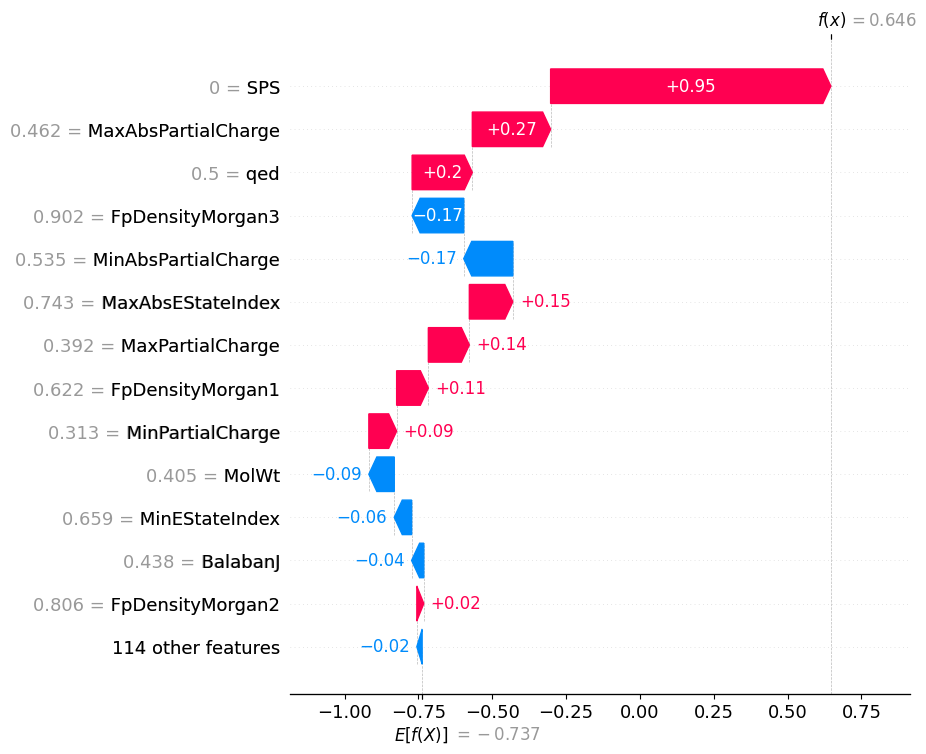

In [40]:

X100 = shap.utils.sample(X, 100)
sample_ind = 20
explainer_xgb = shap.Explainer(model, X100)
shap_values_xgb = explainer_xgb(X)
shap.plots.waterfall(shap_values_xgb[sample_ind], max_display=14)


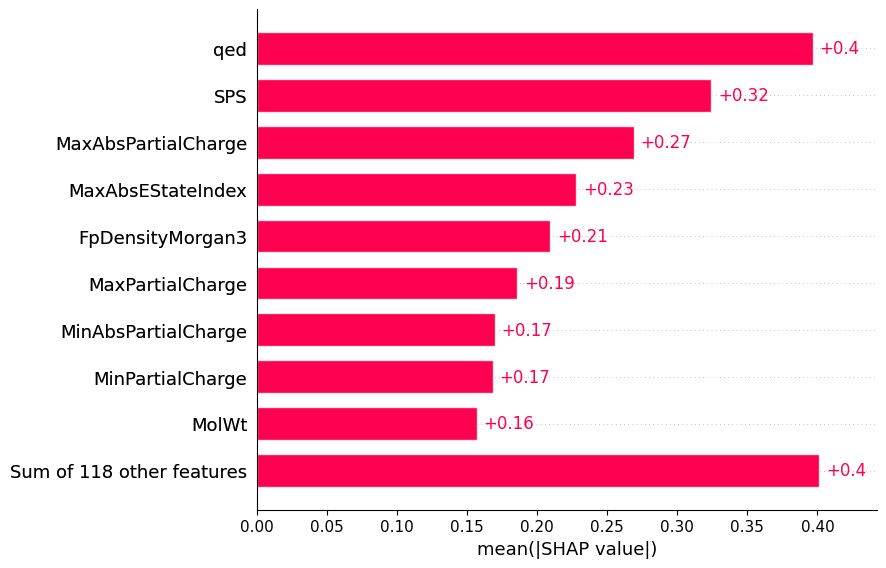

In [41]:
#absolutna hodnota aj kladnej aj zapornej
shap.plots.bar(shap_values_xgb)

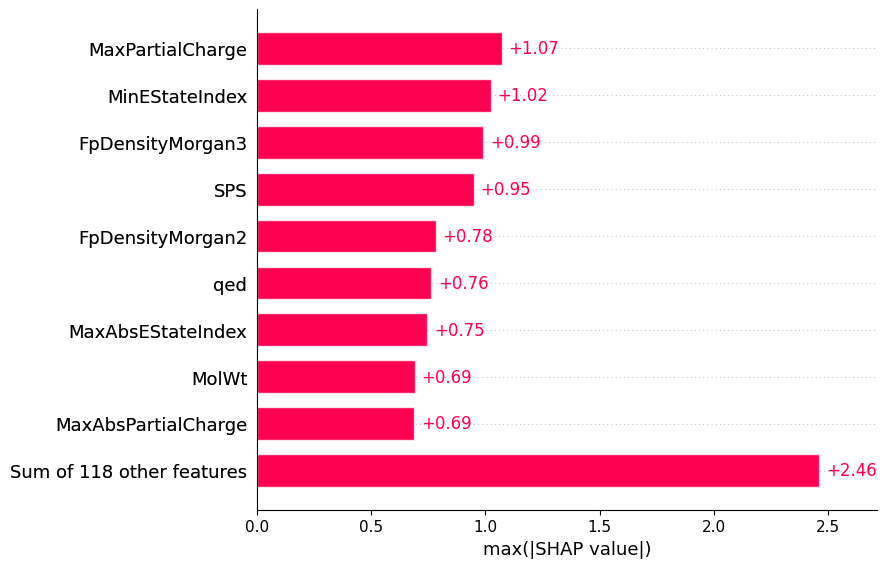

In [42]:
#kladne iba
shap.plots.bar(shap_values_xgb.abs.max(0))

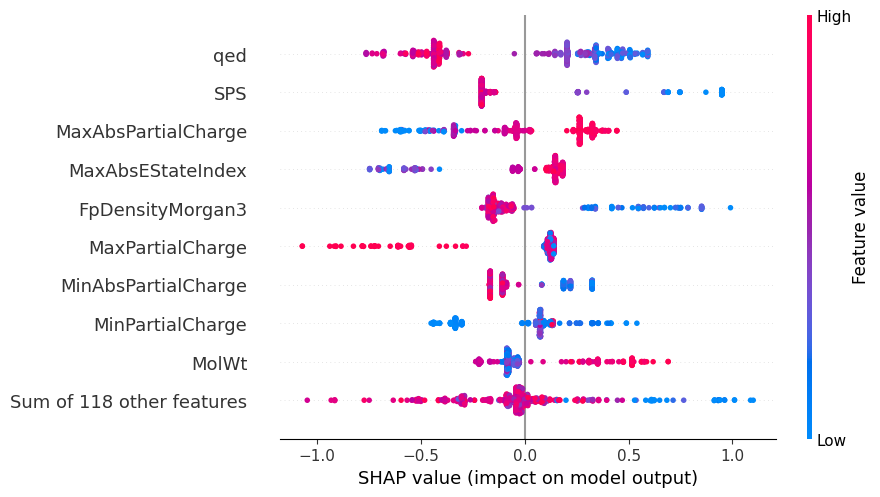

In [43]:
#Distribucia pre zložitejšie prípady 
shap.plots.beeswarm(shap_values_xgb)

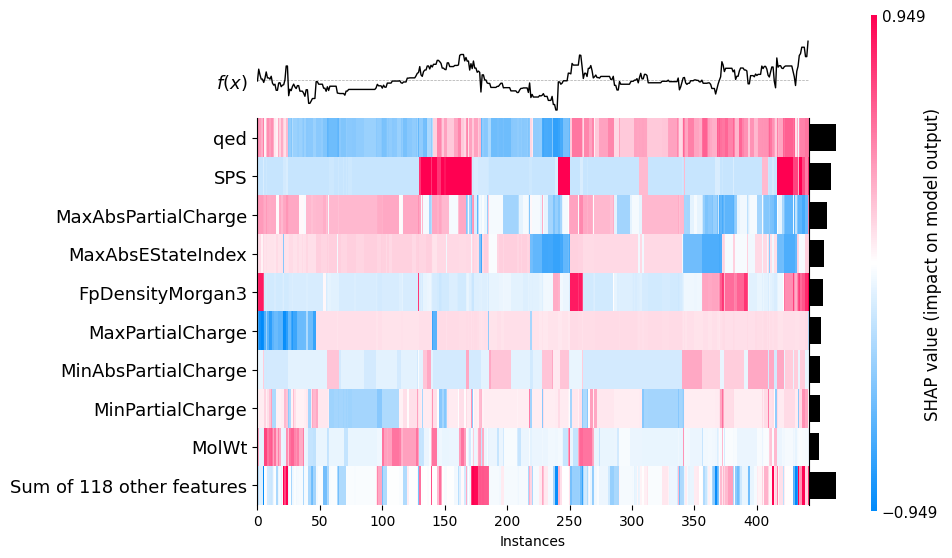

In [44]:
shap.plots.heatmap(shap_values_xgb[:1000])

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [50]:
def order_descriptors(shap_values, df):
    # Convert SHAP values to absolute values and calculate mean
    abs_shap_values = np.abs(shap_values)
    mean_abs_shap_values = np.mean(abs_shap_values, axis=0)

    # Get column names from df
    column_names = df.columns

    # Calculate mean importance across all samples
    mean_importance = np.mean(mean_abs_shap_values, axis=0)

    # Combine feature names with mean SHAP values
    feature_importance_df = pd.DataFrame({'Feature': column_names, 'Mean_Shap_Value': mean_importance})

    # Sort features by mean importance in descending order
    sorted_features = feature_importance_df.sort_values(by='Mean_Shap_Value', ascending=False)


    return  sorted_features

In [46]:
def feature_selection(features, model):
    # Create SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)
    shap_values = np.swapaxes(np.swapaxes(shap_values, 0, 2), 1, 2)

    sorted_features = order_descriptors(shap_values, X_train)
    print(sorted_features.head(features))

    top_features = sorted_features["Feature"].head(features).tolist()

    X_train_selected =  X_train[top_features]
    X_test_selected = X_test[top_features]

    return X_train_selected, X_test_selected

In [47]:
def random_forest(X_train, X_test, y_train, y_test):

    param_grid = {
        'n_estimators': [10, 20, 30, 40],
        'max_depth': [3, 5],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [10, 15],
        'max_features': ['sqrt', 'log2', None],
        'min_impurity_decrease': [0.05, 0.1, 0.2]
    }

    # Create a random forest classifier
    rf = RandomForestClassifier(warm_start=True)

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    # Instantiate the grid search with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=0)

    # Perform grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    print("Best parameters found:", best_params)

    # Use the best model to make predictions on the test set
    best_model = grid_search.best_estimator_

    # Perform predictions on the training dataset
    y_pred_train = best_model.predict(X_train)

    # Make predictions on the test set
    y_pred_test = best_model.predict(X_test)

    print_score(y_train, y_pred_train, y_test, y_pred_test)

    return best_model

In [48]:
model = random_forest(X_train, X_test, y_train, y_test)

Best parameters found: {'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 30}
75.64%
74.16%
69.39%
80.95%


In [51]:
X_train_selected, X_test_selected = feature_selection(15, model)
model = random_forest(X_train_selected, X_test_selected, y_train, y_test)

               Feature  Mean_Shap_Value
15             BertzCT         0.026321
18       HallKierAlpha         0.022026
36           PEOE_VSA9         0.021330
56                TPSA         0.018143
46          SlogP_VSA1         0.018099
13              AvgIpc         0.014547
5                MolWt         0.013877
69         VSA_EState2         0.012538
16               Chi2v         0.012365
0    MaxAbsEStateIndex         0.010723
86       NumHAcceptors         0.005997
89   NumRotatableBonds         0.005166
79             NOCount         0.004121
118          fr_ketone         0.000000
82   NumAliphaticRings         0.000000
Best parameters found: {'max_depth': 3, 'max_features': 'log2', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 30}
76.49%
70.79%
65.38%
80.95%


In [52]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_selected)
print(shap_values.shape)
print(X_train_selected.shape)


(353, 15, 2)
(353, 15)


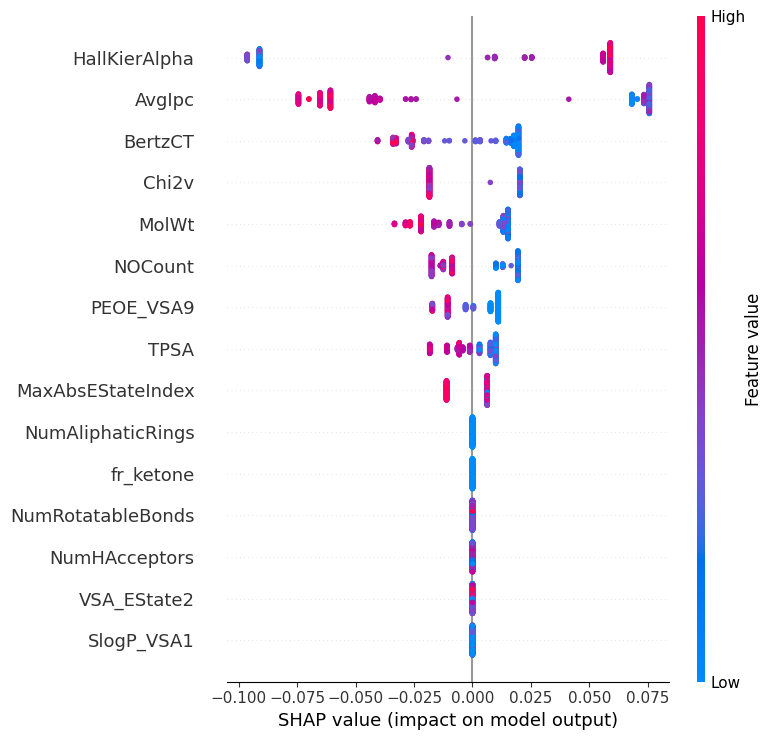

In [53]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

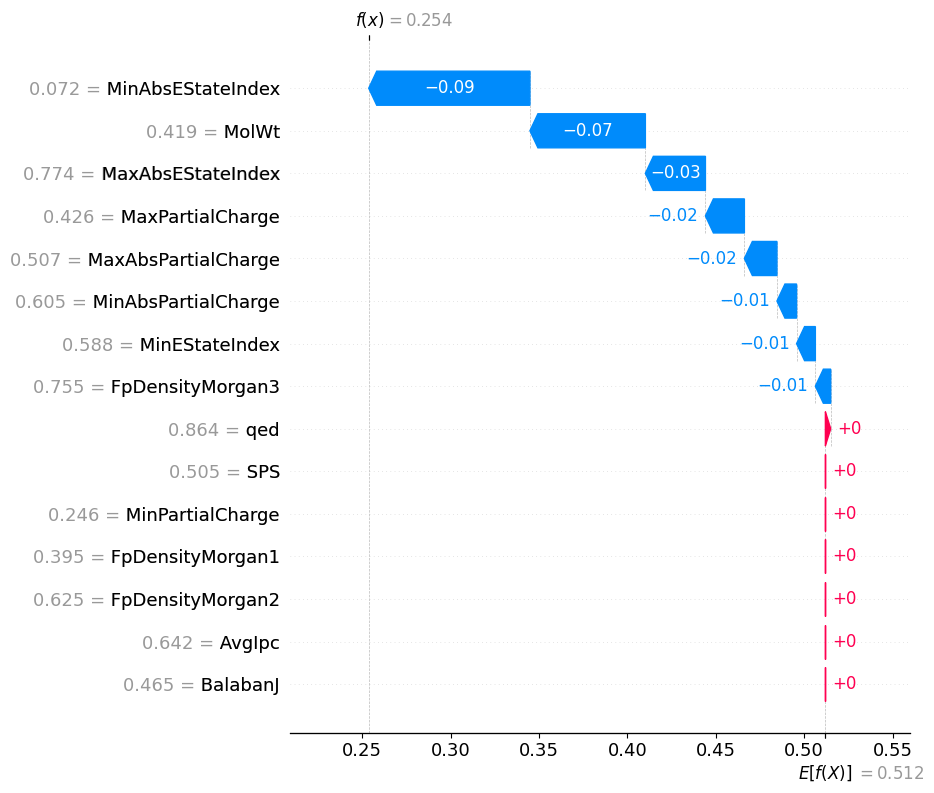

In [54]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

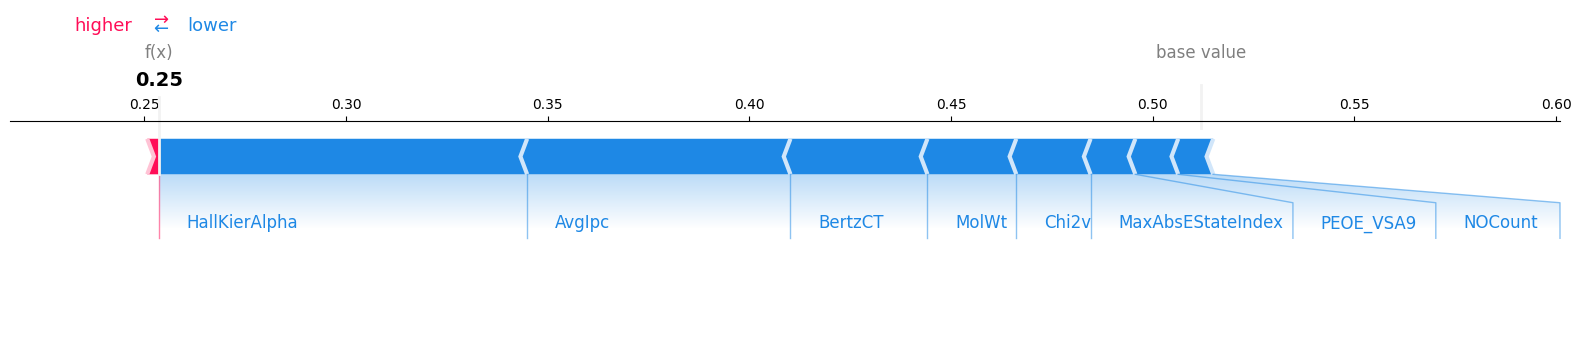

In [55]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz

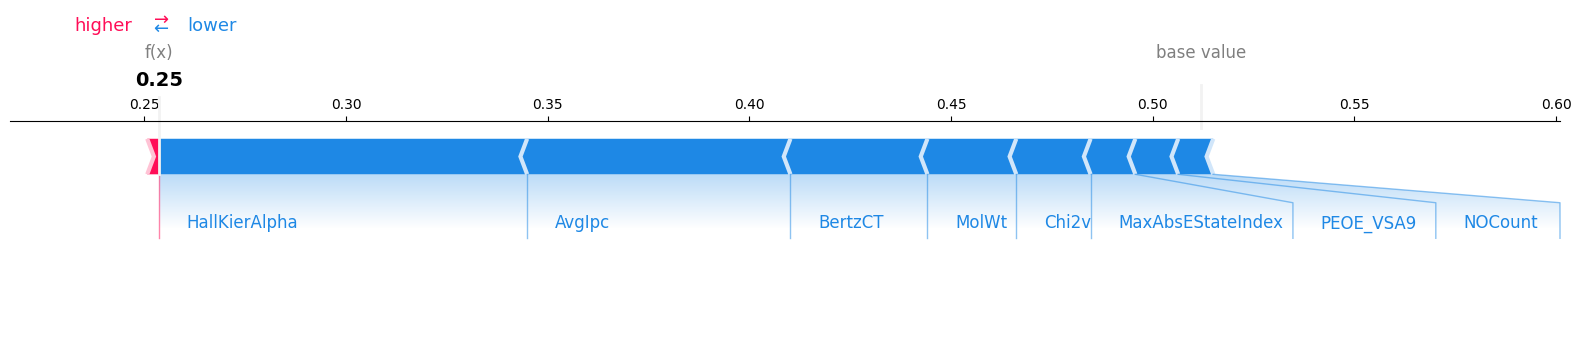

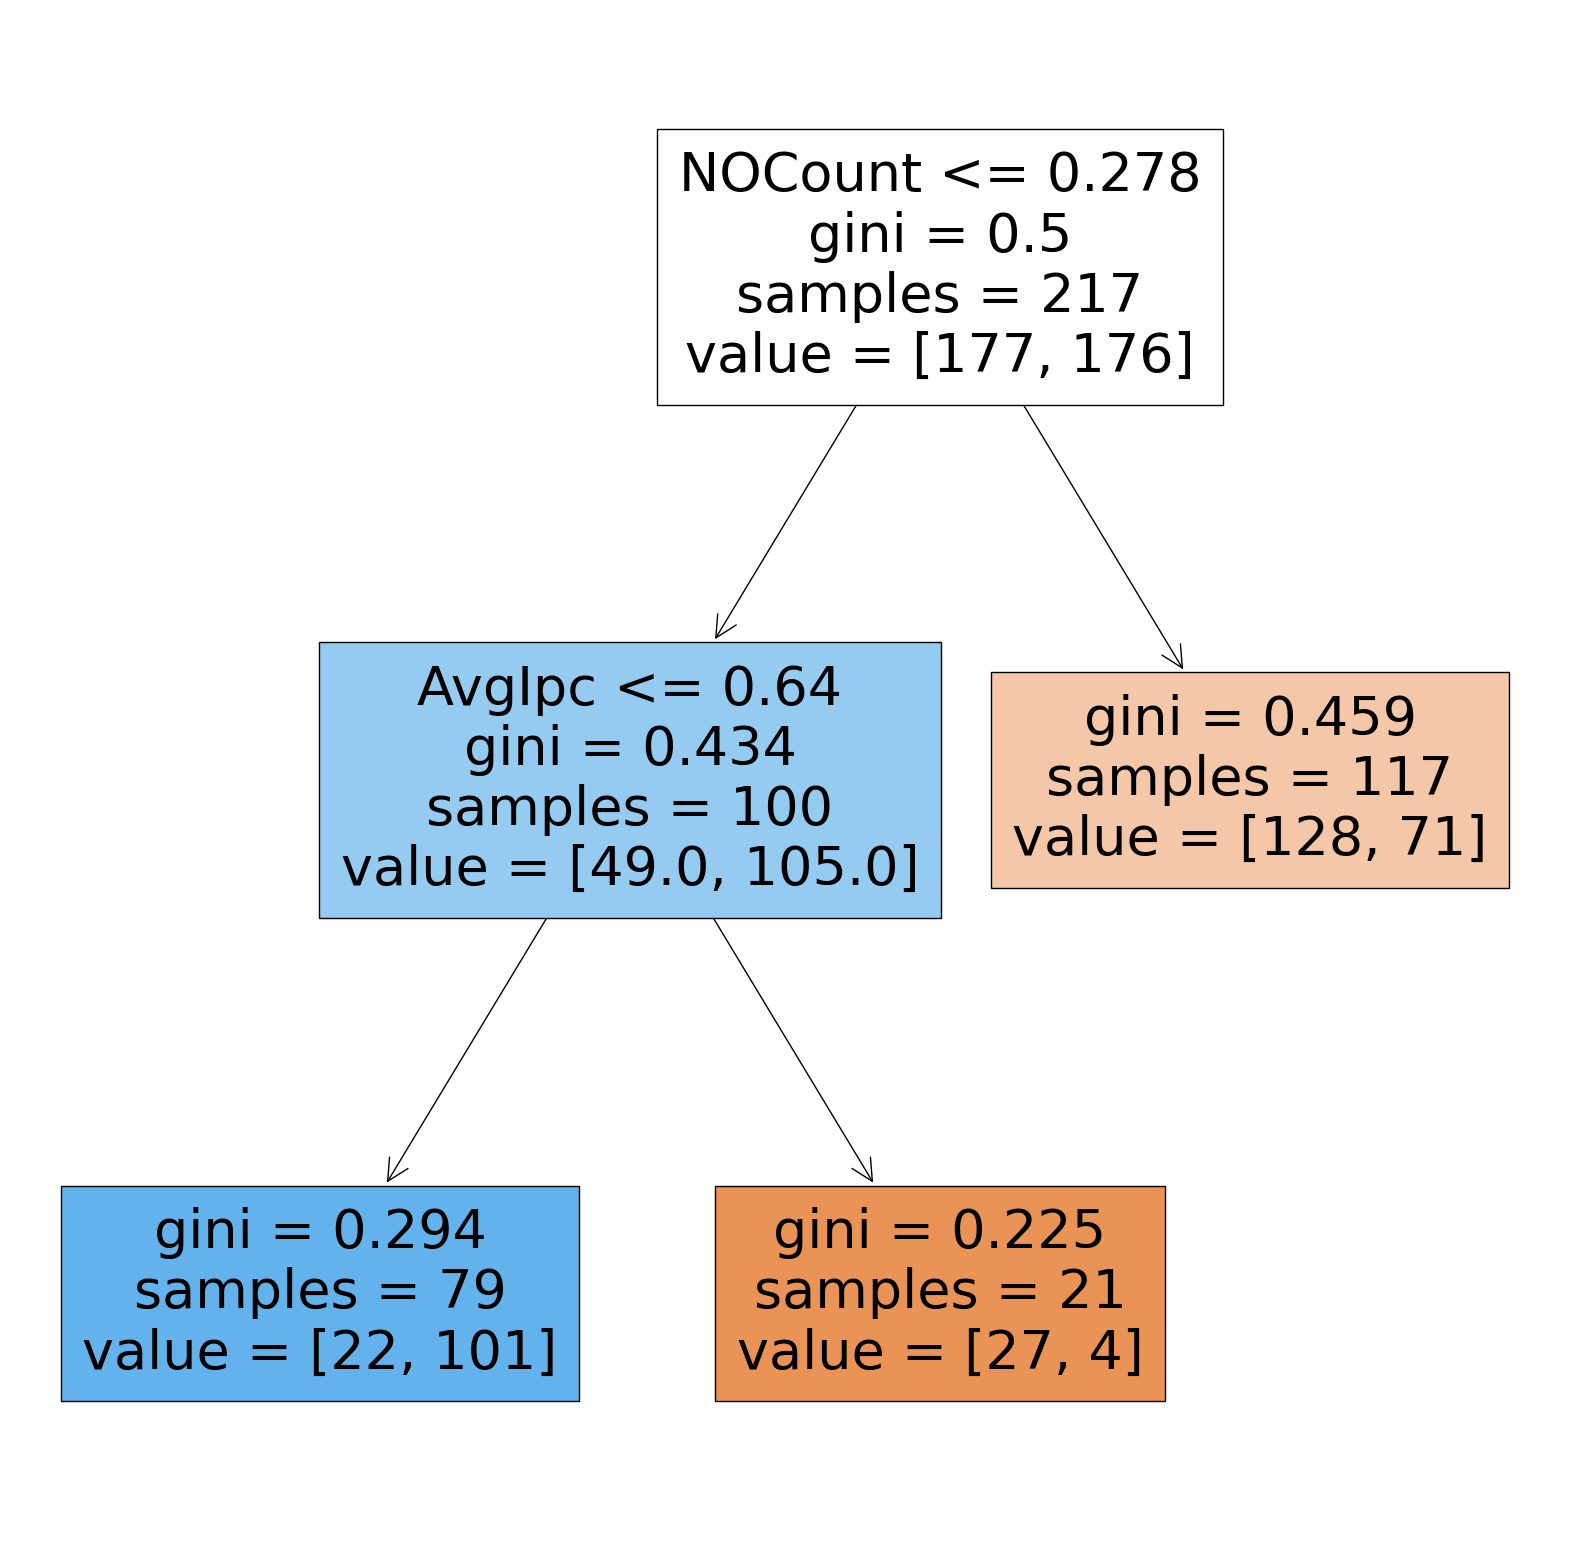

In [57]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Accessing the first decision tree
first_tree = model.estimators_[0]  

# Adjusting the figure size
plt.figure(figsize=(20,20))

# Plotting the entire tree
plot_tree(first_tree, feature_names=model.feature_names_in_, filled=True)

# Saving the tree visualization to an image file
plt.savefig('decision_tree.png')

# Displaying the tree visualization
plt.show()


In [86]:
from sklearn.neighbors import KNeighborsClassifier

In [87]:
def kernel_feature_selection(model):
    background_summary = shap.sample(X_train, 100)
    explainer = shap.KernelExplainer(model.predict_proba, background_summary)

    shap_values = explainer.shap_values(X_train)
    shap_values = np.swapaxes(np.swapaxes(shap_values, 0, 2), 1, 2)
    #shap.summary_plot(shap_values, X_train)

    

    sorted_features = order_descriptors(shap_values, X_train)
    return sorted_features

In [88]:
def get_features(num_features, sorted_features):
    print(sorted_features.head(num_features))

    top_features = sorted_features["Feature"].head(num_features).tolist()

    X_train_selected =  X_train[top_features]
    X_test_selected = X_test[top_features]

    return X_train_selected, X_test_selected

In [89]:
def knn(X_train, X_test, y_train, y_test):
    # Define the parameter grid
    param_grid = {
        'n_neighbors': [4, 5, 7, 9 , 11, 14]  # Define different values for the number of neighbors
    }

    # Create a KNN classifier
    knn_model = KNeighborsClassifier()

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best parameters found:", best_params)
    print("Best training score:", best_score)

    # Use the best model to make predictions on the validation set
    best_model = grid_search.best_estimator_

    best_model.fit(X_train, y_train)

    y_pred_train = best_model.predict(X_train)

    # Make predictions on the validation set
    y_pred_valid = best_model.predict(X_test)

    print_score(y_train, y_pred_train, y_test, y_pred_valid)
    return best_model

In [90]:
model = knn(X_train, X_test, y_train, y_test)

Best parameters found: {'n_neighbors': 5}
Best training score: 0.7788329979879276
83.85%
77.53%
70.91%
90.70%


In [91]:
sorted_features = kernel_feature_selection(model)

  0%|          | 0/353 [00:00<?, ?it/s]

In [92]:
X_train_selected, X_test_selected = get_features(9, sorted_features) 
model = knn(X_train_selected, X_test_selected, y_train, y_test)

              Feature  Mean_Shap_Value
85   NumAromaticRings         0.020286
24         PEOE_VSA10         0.018279
102            fr_C_O         0.016732
103      fr_C_O_noCOO         0.015579
78          NHOHCount         0.014420
23          PEOE_VSA1         0.013871
114          fr_ether         0.013423
40           SMR_VSA3         0.012707
41           SMR_VSA4         0.012180
Best parameters found: {'n_neighbors': 7}
Best training score: 0.7336418511066398
79.60%
68.54%
62.71%
86.05%


In [54]:
background_summary = shap.sample(X_train_selected, 100)
explainer = shap.KernelExplainer(model.predict_proba, background_summary)

shap_values = explainer.shap_values(X_train_selected)


  0%|          | 0/303 [00:00<?, ?it/s]

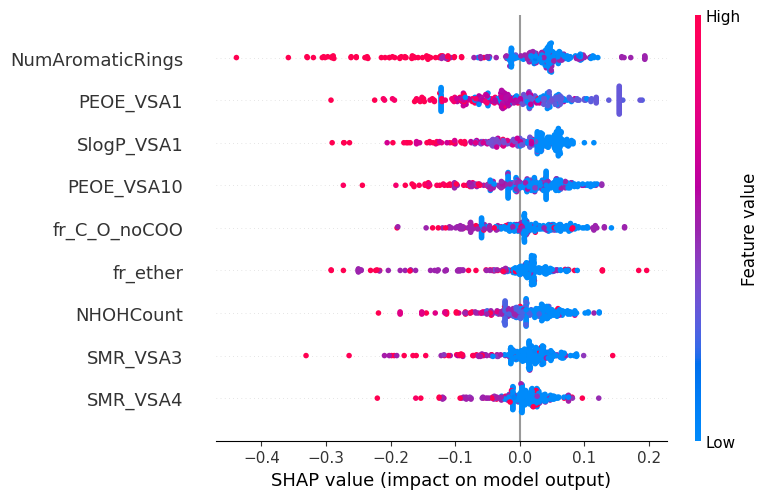

In [55]:
shap.summary_plot(shap_values[:,:,1], X_train_selected)

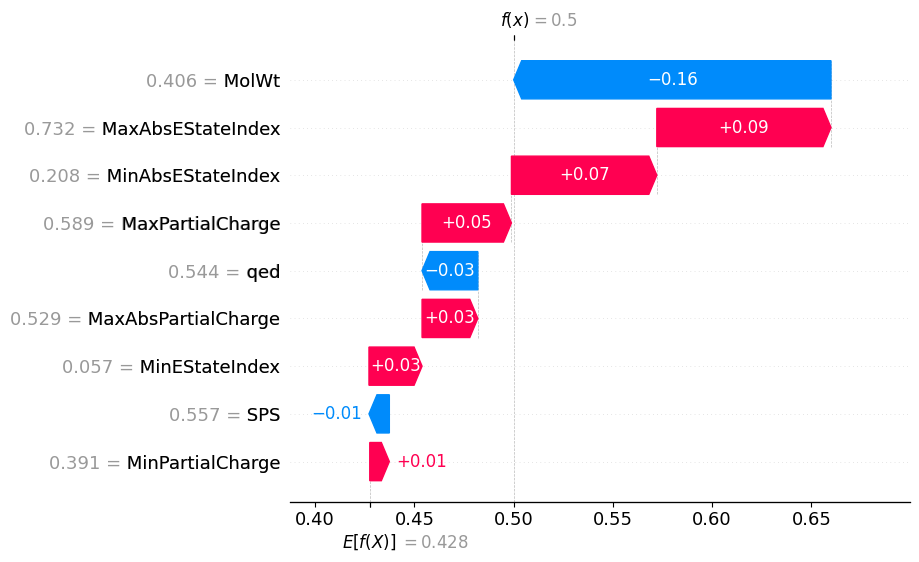

In [56]:
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index,:,1], base_values=explainer.expected_value[1], data=X_test.iloc[index,:]), max_display=20)

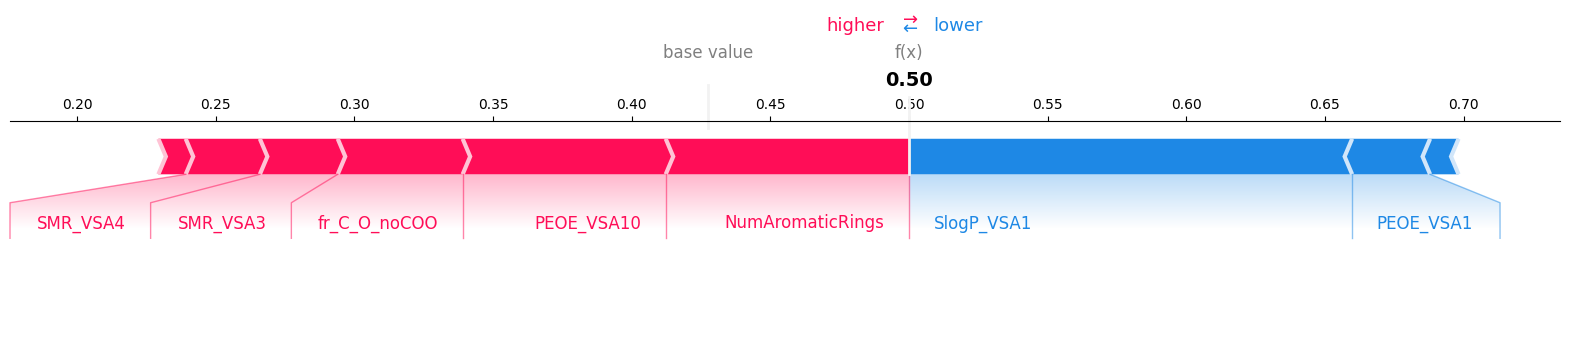

In [57]:
shap.force_plot(explainer.expected_value[1], shap_values[index,:,1], feature_names=X_train_selected.columns, matplotlib=True, show=False)

In [61]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.svm import SVC
from scipy.stats import uniform

In [62]:
def svm(X_train, X_test, y_train, y_test):

    # Define the parameter distribution for randomized search
    param_dist = {'C': uniform(loc=0.1, scale=10)}

    # Create SVM classifier
    svm_model = SVC(kernel='rbf', probability=True)

    # Perform randomized search
    random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=-1)

    # Fit randomized search to the training data
    random_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    print("Best parameters found:", best_params)
    print("Best training score:", best_score)

    # Use the best model to make predictions on the validation set
    best_svm_model = random_search.best_estimator_
    y_pred_train = best_svm_model.predict(X_train)
    y_pred_valid = best_svm_model.predict(X_test)

    # Evaluate the model
    print_score(y_train, y_pred_train, y_test, y_pred_valid)
    return best_svm_model

In [63]:
model = svm(X_train, X_test, y_train, y_test)

Best parameters found: {'C': 5.71476187760218}
Best training score: 0.8185792349726775
98.02%
76.32%
75.00%
60.00%


In [64]:
sorted_features = kernel_feature_selection(model)

  0%|          | 0/303 [00:00<?, ?it/s]

In [65]:
X_train_selected, X_test_selected = get_features(5, sorted_features) 
model = svm(X_train_selected, X_test_selected, y_train, y_test)

         Feature  Mean_Shap_Value
24    PEOE_VSA10         0.042793
78  FractionCSP3         0.033137
47   SlogP_VSA10         0.032268
63   EState_VSA5         0.031509
57          TPSA         0.029516
Best parameters found: {'C': 9.573754083942381}
Best training score: 0.7460655737704919
82.51%
61.84%
51.61%
53.33%


In [66]:
import seaborn as sns

In [67]:
sns.pairplot(df)
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103332d00>>
Traceback (most recent call last):
  File "/Users/monika/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Get support vectors
support_vectors = svm.support_vectors_

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_selected)
support_vectors_pca = pca.transform(support_vectors)

# Plot the data points
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k', label='Data points')
# Plot the support vectors
plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100, facecolors='none', edgecolors='k', linewidths=2, label='Support vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Support Vectors Plot')
plt.legend()
plt.show()